In [518]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay, make_scorer
from sklearn.model_selection import learning_curve
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC




import warnings
warnings.filterwarnings('ignore')

In [519]:
#data_transformed = pd.read_csv('new_data/clean-data_without_outliers.csv')
#competition_transformed = pd.read_csv('new_data/clean-comp.csv')
#data = pd.read_csv('new_data/clean-data_without_outliers.csv')
competition = pd.read_csv('new_data/clean-comp.csv')

data = pd.read_csv('new_data/complete-data.csv')
#data_transformed

In [520]:
data.sort_values('year')

,playerID,year,tmID,GP,oRebounds,dRebounds,dq,ft%,fg%,three%,...,weight,award_count,career_year,playoff_progression_rolling,playoff_rolling,pp36_rolling,eff_rolling,award_count_rolling,defensive_prowess_rolling,defensive_discipline_rolling
691,397,3,573,24.0,1.38,1.83,0.00,0.61,0.41,0.00,...,150,0.0,3,0.5,0.5,11.34,-112.170,0.0,24.65,5.90
287,191,3,568,3.0,0.33,0.33,0.00,0.75,0.50,0.00,...,180,0.0,3,1.5,1.0,15.12,-100.605,0.0,30.65,6.40
97,70,3,559,32.0,1.44,4.38,0.00,0.83,0.46,0.40,...,185,0.0,3,0.5,0.5,10.26,-212.575,0.0,79.70,8.90
284,187,3,573,32.0,0.50,1.50,0.00,0.76,0.38,0.32,...,165,0.0,3,0.0,0.0,12.24,-171.655,0.0,22.05,6.06
900,504,3,558,32.0,0.97,3.98,0.05,1.70,0.71,0.83,...,138,0.0,3,2.5,1.0,6.30,-101.850,0.0,33.90,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,247,11,556,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,196,0.0,9,0.5,0.5,19.98,-267.790,0.0,53.75,10.39
424,260,11,574,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,180,0.0,6,1.0,0.5,12.42,-228.340,0.0,54.55,8.59
427,262,11,745,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,175,0.0,5,0.5,0.5,10.44,-131.025,0.0,20.25,6.59
836,466,11,573,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,168,0.0,9,4.0,1.0,20.52,-173.405,0.0,46.45,10.29


In [521]:
#make a teams_conf dictionary by getting unique pairs of teams and conferences
teams_conf = data[['tmID', 'confID']].drop_duplicates()
teams_conf = dict(zip(teams_conf.tmID, teams_conf.confID))

In [522]:
competition.columns

Index(['playerID', 'year', 'stint', 'tmID', 'height', 'weight', 'pos',
       'college', 'confID'],
      dtype='object')

In [523]:
input_cols = ['playerID', 'year', 'tmID', 'pos', 'college', 'height', 'weight', 'career_year', 'confID']

#add all columns ending in rolling from data to input cols
input_cols+=[c for c in data.columns if c.endswith("_rolling")]

# The output columns are the genres
output_cols = 'playoff'

known_columns = ['playerID', 'year', 'tmID', 'height', 'weight', 'pos','college', 'confID']

# Averages to calculate for precision, recall, and f1-score
averages = [None, "macro", "weighted", "micro", "samples"]

print(input_cols)

['playerID', 'year', 'tmID', 'pos', 'college', 'height', 'weight', 'career_year', 'confID', 'playoff_progression_rolling', 'playoff_rolling', 'pp36_rolling', 'eff_rolling', 'award_count_rolling', 'defensive_prowess_rolling', 'defensive_discipline_rolling']


In [524]:
#drop any columns that are not in input_cols or output_cols
data = data[input_cols+[output_cols]]

In [525]:
param_dists = {
        RandomForestClassifier: { #for accuracy, low computational cost
            'n_estimators': [20,40],
            'criterion': ['gini', 'entropy'],
            'random_state': [16, 256],
            'max_depth': [6],
            'max_leaf_nodes': [9],
            'min_samples_split': [4],
            'min_samples_leaf': [2],
        },
        KNeighborsClassifier: { #for accuracy
            'n_neighbors': [30,50],
            'weights': ['uniform', 'distance'],
            'leaf_size': [12,28,40],
            'metric': ['chebyshev', 'hamming'],
        },
        SVC: {
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 1],
            'kernel': ['rbf'],
            'shrinking': [True, False],
            'decision_function_shape': ['ovo', 'ovr'],
        },
        DecisionTreeClassifier: { #for accuracy (the choice is binary, but the criterion is entropy)
            'criterion': ['gini', 'entropy'],
            'max_depth': [ 6, 9],
            'max_leaf_nodes': [9],
            'min_samples_split': [4]
        },
        MLPClassifier: { #for accuracy
            'hidden_layer_sizes': [(50,100,50)],
            'activation': ['tanh', 'relu'],
        },
        BaggingClassifier: {
            'n_estimators': [10, 20],
            'max_samples': [0.5, 1.0],
            'bootstrap': [True, False],
            'bootstrap_features': [True, False],
            'warm_start': [True, False],
        },
        SGDClassifier: {    #for accuracy
            'loss': ['hinge', 'log', 'perceptron'],
            'alpha': [0.0001, 0.1],
            'learning_rate': ['constant', 'adaptive'],
            'eta0': [0.01, 10],
            'power_t': [0.1, 5],
        },
        LGBMClassifier: {  #for accuracy, low computational cost
            'num_leaves': [10, 100],
            'max_depth': [3, 10],
            'silent': [True, False],
            'importance_type': ['split'],
        },
        LogisticRegression: {  # for accuracy
            'penalty': ['l2'],  # 'l1' and 'elasticnet' might require the 'saga' solver, which is slower
            'C': [0.1, 1, 10],  # fewer values, spread across orders of magnitude
            'solver': ['lbfgs'],  # only include solvers that work well with 'l2'
            'max_iter': [500]  # reduced max iterations
        }
    }

In [526]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from imblearn.pipeline import Pipeline

def plot_learning_curve(
    title,
    train_sizes, 
    train_scores, 
    test_scores, 
    fit_times,
    score_times,
    axes=None,
    ylim=None,
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    axes = axes.reshape(-1)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    fig = fig.delaxes(axes[-1])
    
    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    # Plot n_samples vs score_times
    axes[3].grid()
    axes[3].plot(train_sizes, score_times_mean, "o-")
    axes[3].fill_between(
        train_sizes,
        score_times_mean - score_times_std,
        score_times_mean + score_times_std,
        alpha=0.1,
    )
    axes[3].set_xlabel("Training examples")
    axes[3].set_ylabel("score_times")
    axes[3].set_title("Scalability of the model")

    # Plot score_time vs score
    score_time_argsort = score_times_mean.argsort()
    score_time_sorted = score_times_mean[score_time_argsort]
    test_scores_mean_sorted = test_scores_mean[score_time_argsort]
    test_scores_std_sorted = test_scores_std[score_time_argsort]
    axes[4].grid()
    axes[4].plot(score_time_sorted, test_scores_mean_sorted, "o-")
    axes[4].fill_between(
        score_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[4].set_xlabel("score_times")
    axes[4].set_ylabel("Score")
    axes[4].set_title("Performance of the model")

    return plt

In [527]:
model = DecisionTreeClassifier()
#loop in rolling window method through all data
unique_years = data['year'].unique()
#sort the years
unique_years.sort()
rolling_window_results = []
competition_predictions = []
trained_models = list()
predited_teams = list()
actual_teams = list()



print(unique_years)


[ 3  4  5  6  7  8  9 10 11]


In [528]:
def get_columns_to_remove():
    return ['playoff']

In [529]:

toZeroArr = [c for c in data.columns if c not in input_cols]
#add playoff to the list of columns to remove
toZeroArr.remove('playoff')
print(toZeroArr)

[]


In [530]:
def prepare_training_data(data, unique_years, i):
    train_years_before = unique_years[:i]
    train_years = unique_years[:i+1]
    test_year = unique_years[i]

    if i + 1 > len(unique_years): 
        return

    predict_year = unique_years[i+1]  # Predicting for year i+2 

    if predict_year < test_year:
        return
    # print("Train years:", train_years)
    # print("Predict Year: ", predict_year)
    
    train_before = data[data['year'].isin(train_years_before)]
    train = data[data['year'].isin(train_years)]
    test = data[data['year'] == test_year]
    actual = data[data['year'] == predict_year]

    return train_before, train, test, actual, predict_year, train_years, test_year


In [531]:

def process_data(train_before, train, test, actual, data, unique_years):

    remove_columns = get_columns_to_remove()
    actual[toZeroArr] = 0

    X_train = train.drop(remove_columns, axis=1)
    y_train = train[output_cols]
    X_actual = actual.drop(remove_columns, axis=1)
    y_actual = actual[output_cols]


    return X_train, y_train, X_actual, y_actual


In [532]:
def train_and_evaluate_model(X_train, y_train, model, n_iter, random_state=42, oversample=False):
    if oversample:
        smt = SMOTETomek(random_state=42)
        X_train, y_train = smt.fit_resample(X_train, y_train)
    parameters = param_dists.get(type(model), {})
    
    if n_iter == None:
        model = RandomizedSearchCV(model, parameters, scoring='accuracy', cv=5, verbose=0, random_state=random_state)
    else:
        model = GridSearchCV(model, parameters, scoring='accuracy', cv=5, verbose=0)

    classifier = model.fit(X_train, y_train)
    return classifier


In [533]:

def predict_and_evaluate(classifier, X_actual, y_actual):
    accuracy = 0.0
    auc_score = 0.0


    predictions = classifier.predict(X_actual)
    predictions_prob = classifier.predict_proba(X_actual)[:, 1]

    if X_actual['year'].unique()[0]==11:
        competition_predictions.append(predictions)
    else:
        accuracy = accuracy_score(y_actual, predictions)
        #auc_score = roc_auc_score(y_actual, predictions_prob, multi_class='ovr')

    return accuracy, auc_score, predictions, predictions_prob


In [534]:
def get_team_prediction(X_actual, predicted, actual):
    #make a dictionary of the player and their predicted
    player_prediction = dict(zip(X_actual['playerID'], predicted))
    #get the unique teams
    teams = X_actual['tmID'].unique()
    #make a dictionary of the team and the prediction
    team_prediction = dict()
    for team in teams:
        team_prediction[team] = 0
    #loop through the player predictions and make the mean for the team
    for player in player_prediction:
        team_prediction[X_actual[X_actual['playerID']==player]['tmID'].values[0]] += player_prediction[player]
    #divide by the number of players on the team
    for team in team_prediction:
        team_prediction[team] = team_prediction[team]/len(X_actual[X_actual['tmID']==team])
    #add the actual team
    teams_actual = dict()
    for i in range(len(actual)):
        team = X_actual.iloc[i]['tmID']
        playoff = actual.iloc[i]
        if team not in teams_actual:
            teams_actual[team] = playoff
    return team_prediction, teams_actual
        



In [535]:
def make_team_prediction(team_prediction, teams_actual):
    #4 teams from each conference make the playoffs, get the best 4 teams from each conference (get from teams_conf)
    west = [k for k, v in sorted(team_prediction.items(), key=lambda item: item[1], reverse=True) if teams_conf[k]==701][:4]
    east = [k for k, v in sorted(team_prediction.items(), key=lambda item: item[1], reverse=True) if teams_conf[k]==702][:4]
    #get the actual teams
    west_actual = [k for k, v in sorted(teams_actual.items(), key=lambda item: item[1], reverse=True) if teams_conf[k]==701][:4]
    east_actual = [k for k, v in sorted(teams_actual.items(), key=lambda item: item[1], reverse=True) if teams_conf[k]==702][:4]

    return west, east, west_actual, east_actual


In [536]:

def rolling_window_method(i, model, data, unique_years, n_iter):
    train_before, train, test, actual, predict_year, train_years, test_year = prepare_training_data(data, unique_years, i)

    model_name = type(model).__name__
    
    if train_before is None:
        return None

    X_train, y_train, X_actual, y_actual= process_data(train_before, train, test, actual, data, unique_years)


    classifier = train_and_evaluate_model(X_train, y_train, model, n_iter)

    accuracy, auc_score, predictions, predictions_prob = predict_and_evaluate(classifier, X_actual, y_actual)

    teams_prediction, teams_actual = get_team_prediction(X_actual, predictions, y_actual)

    number_of_teams = len(teams_prediction)
    

    west, east, west_actual, east_actual= make_team_prediction(teams_prediction, teams_actual)

    teams_prediction = west + east
    teams_actual = west_actual + east_actual
    
    if isinstance(teams_prediction[0], float):
        teams_prediction = [int(i) for i in teams_prediction]
    if isinstance(teams_actual[0], float):
        teams_actual = [int(i) for i in teams_actual]

    # Calculate TP, FP, FN
    TP = len(set(teams_prediction) & set(teams_actual))
    FP = len(set(teams_prediction) - set(teams_actual))
    FN = len(set(teams_actual) - set(teams_prediction))

    # Calculate TN
    TN = number_of_teams - TP - FP - FN

    # Calculate accuracy
    team_accuracy = (TP + TN) / (TP + TN + FP + FN)

    return {
        'train_years': train_years,
        'test_year': test_year,
        'Year': predict_year,
        'accuracy': accuracy,
        'auc': auc_score,
        'model': classifier,
        'model_name': model_name,
        'predictions': predictions,
        'predictions_prob': predictions_prob,
        'actual_results': y_actual,
        'teams_prediction': teams_prediction,
        'teams_accuracy': team_accuracy,
    }

In [537]:

def model_training_loop(model, data, unique_years, n_iter=None):
    rolling_window_results = []
    for i in range(len(unique_years) - 1):
        result= rolling_window_method(i, model, data, unique_years, n_iter)
        if result:
            rolling_window_results.append(result)
    return rolling_window_results

In [538]:
list_of_models = [
    RandomForestClassifier(),
    KNeighborsClassifier(),
    BaggingClassifier(),
    #SVC(),
    #DecisionTreeClassifier(),
    #MLPClassifier(),
    #SGDClassifier(),
    #LGBMClassifier(),
    #LogisticRegression(),
]

In [539]:
#loop through all the models
for model in list_of_models:
    rolling_window_results += model_training_loop(model, data, unique_years)
    print(model, " done")
    trained_models.append(rolling_window_results[-1]['model'])

RandomForestClassifier()  done
KNeighborsClassifier()  done
BaggingClassifier()  done


In [540]:
level0 = list()
#append models in trained_models to level0
for i in range(len(trained_models)):
    level0.append((str(i), trained_models[i]))

level1 = RandomForestClassifier(n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=9, bootstrap=True, criterion='entropy', random_state=22)
clf = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)

rolling_window_results += model_training_loop(clf, data, unique_years)
trained_models.append(rolling_window_results[-1]['model'])  # Get the last trained model

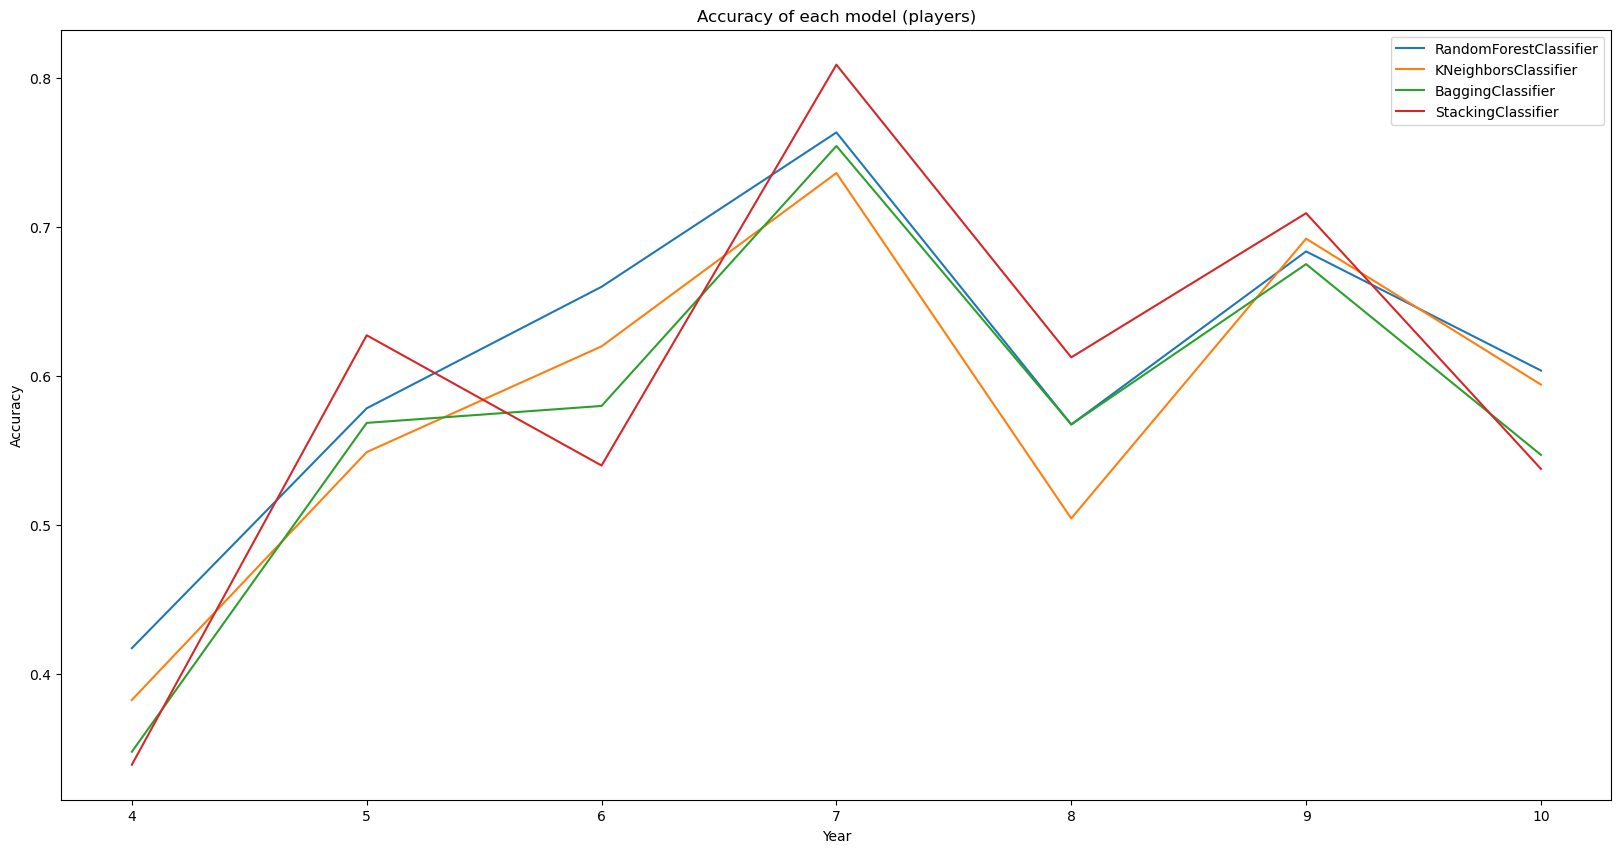

In [541]:
#demora +/- 10 minutos a correr
model_accuracy = dict()
for result in rolling_window_results:
    model_name = result['model_name']
    if model_name not in model_accuracy:
        model_accuracy[model_name] = {'years': [], 'accuracies': []}
    #skip if the year is 11
    if result['Year']==11:
        continue
    model_accuracy[model_name]['years'].append(result['Year'])
    model_accuracy[model_name]['accuracies'].append(result['accuracy'])

# Plot a line graph of the accuracy of each model
plt.figure(figsize=(20, 10))
plt.title("Accuracy of each model (players)")
plt.xlabel("Year")
plt.ylabel("Accuracy")

for model_name, data in model_accuracy.items():
    plt.plot(data['years'], data['accuracies'], label=model_name)

plt.legend()
plt.show()

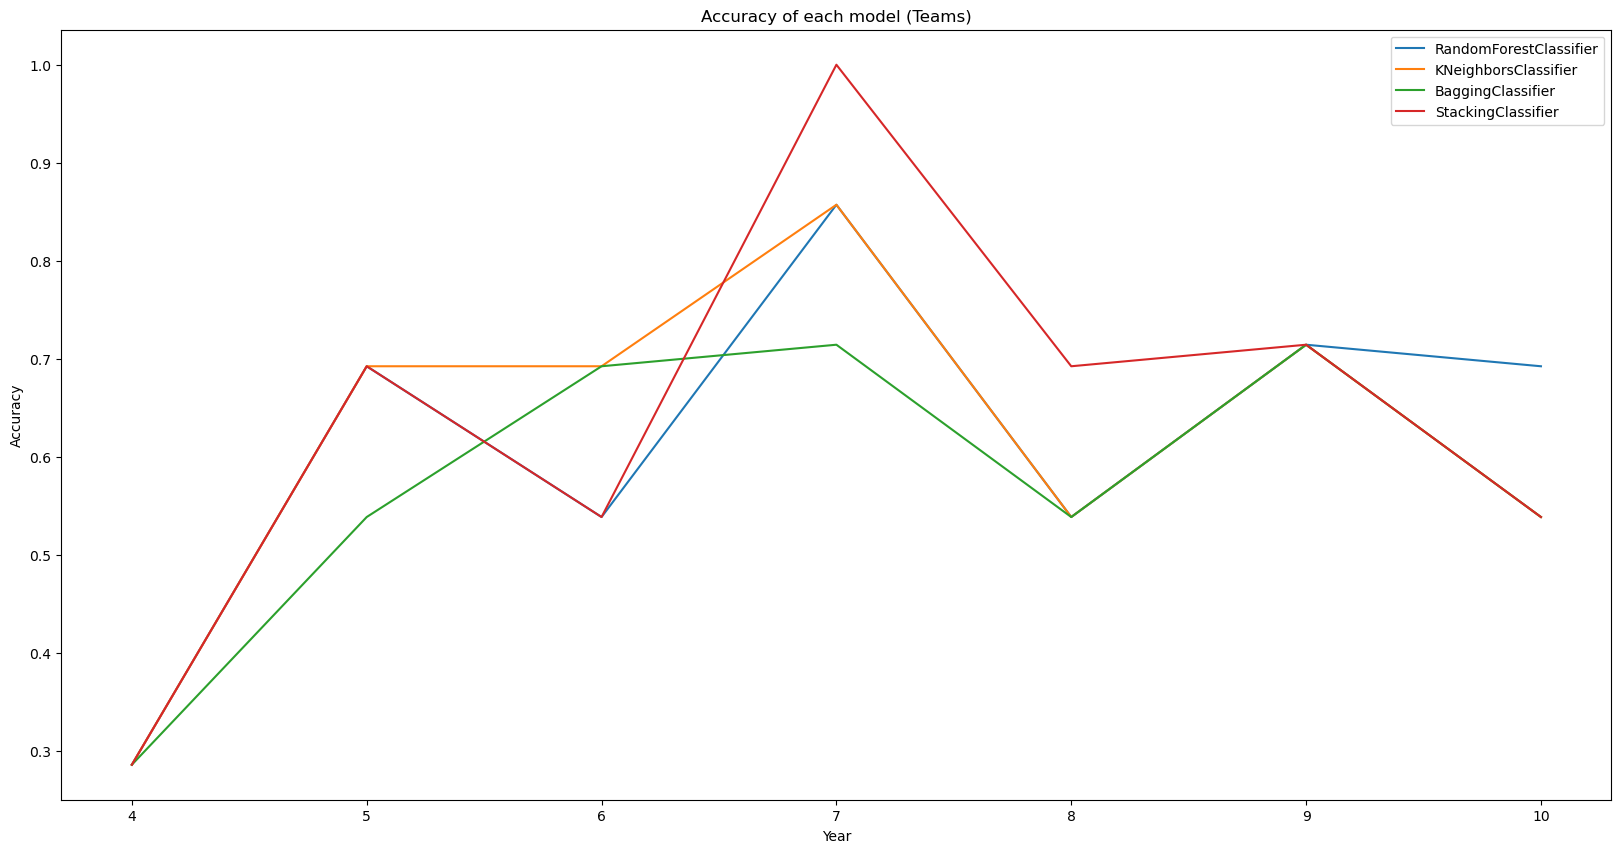

In [542]:
#plot the same but for teams
model_accuracy = dict()
for result in rolling_window_results:
    model_name = result['model_name']
    if model_name not in model_accuracy:
        model_accuracy[model_name] = {'years': [], 'team_accuracies': []}
    #skip if the year is 11
    if result['Year']==11:
        continue
    model_accuracy[model_name]['years'].append(result['Year'])
    model_accuracy[model_name]['team_accuracies'].append(result['teams_accuracy'])

# Plot a line graph of the accuracy of each model
plt.figure(figsize=(20, 10))
plt.title("Accuracy of each model (Teams)")
plt.xlabel("Year")
plt.ylabel("Accuracy")

for model_name, data in model_accuracy.items():
    plt.plot(data['years'], data['team_accuracies'], label=model_name)

plt.legend()
plt.show()